## Linear models

The first obvious approach which we will try to use is to use some linear models. Due to the fact that our data is high correlated we will use linear models with regularization. 

After that we will use PCA-transformation and then simple OLS linear regression to our pca-decorrelated data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib as mpl
import seaborn as sns
from IPython.core.display import HTML
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.linear_model import RidgeCV, LinearRegression
from tqdm import tqdm

In [2]:
np.set_printoptions(suppress=True)

In [3]:
data = pd.read_csv("data/train_without_nans.csv")
data_sub = pd.read_csv("data/test_without_nans.csv")

encoded = pd.read_csv("data/encoded_train.csv")
encoded_sub = pd.read_csv("data/encoded_test.csv")

scaled = pd.read_csv("data/scaled_train.csv")
scaled_sub = pd.read_csv("data/scaled_test.csv")

reduced = pd.read_csv("data/pca50train.csv")
reduced_sub = pd.read_csv("data/pca50test.csv")

## Content

<ol>
    <li><a href="#original-data">Original Data</a>
        <ul>
            <li><a href="#ridge">Ridge Regression</a>
            <ul>
                <li><a href="#ridge-coefficients">Coefficients Analysis</a></li>
                <li><a href="#ridge-feature-selection">Feature selection</a></li>
                <li><a href="#ridge-residuals-analysis">Residuals Analysis</a></li>
                <li><a href="#ridge-submission">Final training and submission</a></li>
            </ul>
            </li> 
        </ul>
    </li>
    <li><a href="#pca-data">PCA-transformed Data</a>
            <ul>
                <li><a href="#ols">OLS Regression</a>
                <li><a href="#ols-coefficients">Coefficients Analysis</a></li>
                <li><a href="#ols-feature-selection">Feature selection</a></li>
                <li><a href="#ols-residuals-anlysis">Residual Analysis</a></li>
                <li><a href="#ols-submission">Final training and submission</a></li>
            </ul>
        </li>
    </li>
    <li><a href="#ridge-general-trend">Ridge for general trend</a></li>
    <li><a href="#conclusions">Conclusions</a></li>
</ol>

<a id="original-data"></a>
## Original Data

First of all we will apply Ridge and Lasso Regressions to the original data

In [4]:
scaled_X, scaled_y = scaled.drop("SalePrice", axis=1), scaled["SalePrice"]

<a id="ridge"></a>
## Ridge Regression

Let's use RidgeCV to evaluate the best regularization parameter and train our model

In [5]:
alphas = [i * 0.2 for i in range(1, 101)]
scaled_ridge_reg = RidgeCV(alphas=alphas, scoring="neg_root_mean_squared_error").fit(scaled_X, scaled_y)
print("BEST ALPHA:", scaled_ridge_reg.alpha_)
print("BEST SCORE:", -scaled_ridge_reg.best_score_)

BEST ALPHA: 16.8
BEST SCORE: 0.14118182899599585


Leave-one-out CV shows that the best alpha parameter in our list seems to be equal to 16.8.

For this alpha we received CV score equal to **0.14118**

<a id="ridge-coefficients"></a>
## Coefficients Analysis

In [6]:
scaled_ridge_coefs = pd.DataFrame({"feature": scaled_X.columns.values, "coefficient": scaled_ridge_reg.coef_})

Let's check what coefficients near each feature we have received. Let's check the most affecting coefficients

In [7]:
scaled_ridge_coefs.iloc[scaled_ridge_coefs["coefficient"].abs().sort_values(ascending=False).index].head(n=5)

feature  coefficient
38       MSZoning_C (all)    -0.109610
68   Neighborhood_Crawfor     0.079305
123      RoofMatl_ClyTile    -0.076447
4             OverallQual     0.075536
84   Neighborhood_StoneBr     0.074765

It's pretty strange from the applied side that the most affecting feature is MSZoning feature with class C. But if we recall that we have encoded all categorical features with one hot we can understand that MSZoning_C (all) feature has only 1\0 values. That means that our model thinks that if the house is in commercial Zone than we need to make a small correction to our prediction. 

And that correction is exactly equal to the first printed coefficient.

Now we can check the most meaningless coefficients in terms of Ridge regression model

In [8]:
scaled_ridge_coefs.iloc[scaled_ridge_coefs["coefficient"].abs().sort_values().index].head(n=5)

feature  coefficient
309       MSSubClass_150     0.000000
138  Exterior1st_ImStucc    -0.000245
35               MiscVal    -0.000330
182          BsmtQual_Fa    -0.000351
173         ExterCond_Po     0.000357

Now we can look how many coefficients have absolute values greater than or equal to 0.01

In [9]:
scaled_ridge_coefs[(scaled_ridge_coefs["coefficient"].abs() >= 0.01)].shape[0]

161

Now let's clear our dataset from non-informative features and see how will our CV score change. 

In [10]:
features2select = scaled_ridge_coefs[(scaled_ridge_coefs["coefficient"].abs() >= 0.01)].feature.values
selected_scaled_ridge_X = scaled_X[features2select]

print(selected_scaled_ridge_X.shape)
alphas = [i * 0.2 for i in range(1, 101)]

selected_scaled_ridge_reg = RidgeCV(alphas=alphas, scoring="neg_root_mean_squared_error").fit(selected_scaled_ridge_X, scaled_y)
print("BEST ALPHA:", selected_scaled_ridge_reg.alpha_)
print("BEST SCORE:", -selected_scaled_ridge_reg.best_score_)

(1459, 161)
BEST ALPHA: 15.4
BEST SCORE: 0.1309010221966548


After cleaning a dataset we received new optimal value of alpha parameter (**15.4**) and in addition which is pretty cool we received new and better CV result: **0.130901**.

This means that we can try to select informative features with respect to the ridge regression

<a id="ridge-feature-selection"></a>
## Feature selection

Now we can use the next approach. Let's bruteforce the coefficients' thresholds for feature selection and look which threshold gives us the best model result.

In [11]:
thresholds = [0.001 * i for i in range(1, 51)]
best_scores = []
best_alphas = []

for threshold in tqdm(thresholds):
    features2select = scaled_ridge_coefs[(scaled_ridge_coefs["coefficient"].abs() >= threshold)].feature.values
    selected_X = scaled_X[features2select]
    
    alphas = [i * 0.2 for i in range(1, 101)]
    selected_scaled_ridge_reg = RidgeCV(alphas=alphas, scoring="neg_root_mean_squared_error").fit(selected_X, scaled_y)

    best_scores.append(-selected_scaled_ridge_reg.best_score_)
    best_alphas.append(selected_scaled_ridge_reg.alpha_)

100%|███████████████████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


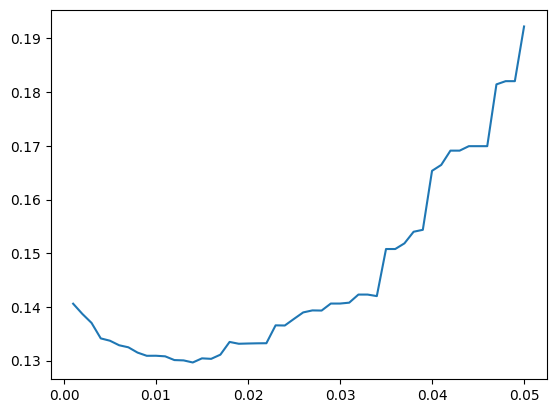

In [12]:
plt.plot(thresholds, best_scores)
plt.show()

In [13]:
print("BEST THRESHOLD:", thresholds[np.argmin(np.array(best_scores))])
print("ALPHA ON THIS THRESHOLD", best_alphas[np.argmin(np.array(best_scores))])

BEST THRESHOLD: 0.014
ALPHA ON THIS THRESHOLD 10.200000000000001


What we see? We see that if we reject all features with coefficients less than 0.014 we will have the best possible CV score on the original scaled data with ridge regression. Let's do it 

In [14]:
features2select = scaled_ridge_coefs[(scaled_ridge_coefs["coefficient"].abs() >= 0.014)].feature.values

selected_scaled_ridge_X = scaled_X[features2select]

print(selected_scaled_ridge_X.shape)

selected_scaled_ridge_reg = RidgeCV(alphas=[10.2], scoring="neg_root_mean_squared_error").fit(selected_scaled_ridge_X, scaled_y)
print("SCORE:", -selected_scaled_ridge_reg.best_score_)

(1459, 122)
SCORE: 0.1296468101285475


Our Leave-one-out CV score seems to be better as before the feature selection (**0.1296468**)

<a id="ridge-residuals-analysis"></a>
## Residuals Analysis

Now we have a dataset with selected informative features. Let's check how our residuals look like

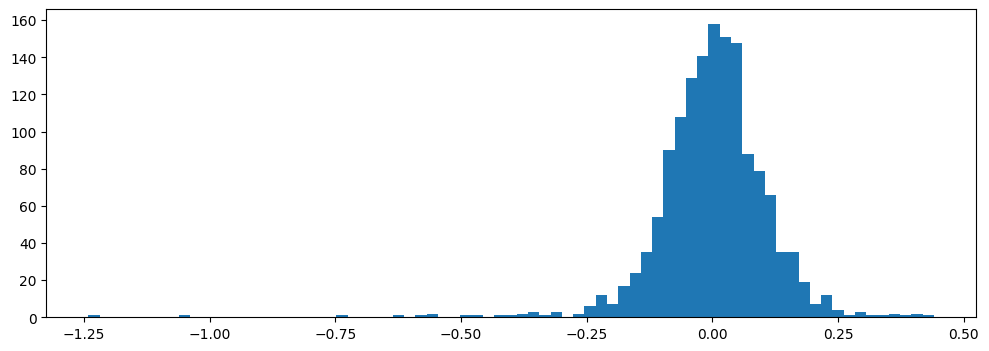

In [15]:
residuals = scaled_y - selected_scaled_ridge_reg.predict(selected_scaled_ridge_X)
residuals = pd.DataFrame({"residuals": residuals})
plt.figure(figsize=(12, 4))
plt.hist(residuals["residuals"], bins=75)
plt.show()

We can observe that some objects have obvious large residuals (absolute) with respect to the whole dataset. 

Let's delete all objects which have residuals bigger than 0.4 (absolute values)

In [16]:
residuals[(residuals["residuals"].abs() > 0.4)].shape[0]

13

There are only 13 objects with absolute residuals greater than 0.4. After the clearing we can once again check which alpha is the best for the cleared data

<a id="ridge-submission"></a>
## Final training and submission

In [17]:
objects2clear_idx = selected_scaled_ridge_X[residuals["residuals"].abs() > 0.4].index

print("IDX OF OBJECTS TO DELETE:", objects2clear_idx)

final_scaled_ridge_X = selected_scaled_ridge_X.copy().drop(objects2clear_idx)
final_scaled_ridge_y = scaled_y.copy().drop(objects2clear_idx)

alphas = [i * 0.2 for i in range(1, 101)]

print(final_scaled_ridge_X.shape)

final_scaled_ridge_reg = RidgeCV(alphas=alphas, 
                                 scoring="neg_root_mean_squared_error").fit(final_scaled_ridge_X, final_scaled_ridge_y)

print("BEST ALPHA:", final_scaled_ridge_reg.alpha_)
print("BEST SCORE:", -final_scaled_ridge_reg.best_score_)

IDX OF OBJECTS TO DELETE: Index([30, 88, 328, 462, 495, 523, 632, 710, 916, 968, 970, 1298, 1324], dtype='int64')
(1446, 122)
BEST ALPHA: 6.2
BEST SCORE: 0.09815159554327699


What we see? We see that those 13 objects had pretty strong affect on our model because after their removing we received **0.09815159** CV score on the remaining data. Generally we can say that 13 objects must not affect the whole picture of our dataset but from the other side they really spoil the linear picture in the data.

Let's check the new received residuals and try to visualize them

In [18]:
final_scaled_ridge_residuals = final_scaled_ridge_y - final_scaled_ridge_reg.predict(final_scaled_ridge_X)

First of all we can try to visualize the residuals with respect to our predicted values to check the homoscedasticity of our data at least visually

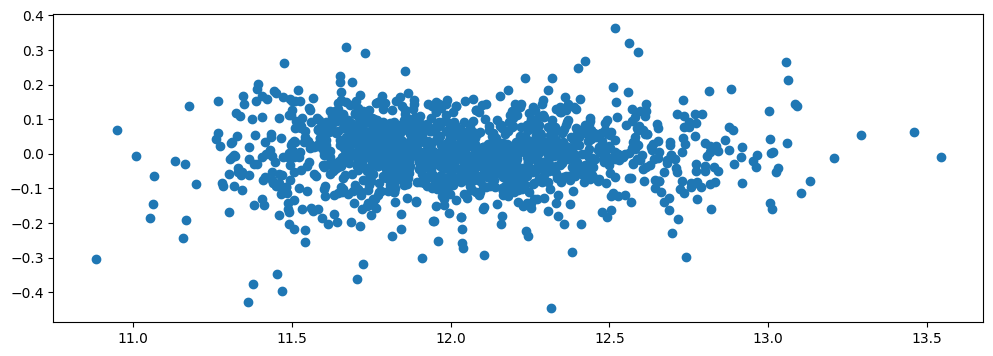

In [19]:
plt.figure(figsize=(12, 4))
plt.scatter(final_scaled_ridge_reg.predict(final_scaled_ridge_X), final_scaled_ridge_residuals)

From the scatter plot we can observe that we have no obvious heteroscedasticity in our data. 

Let's visualize our residuals in 3d with respect to some principal components

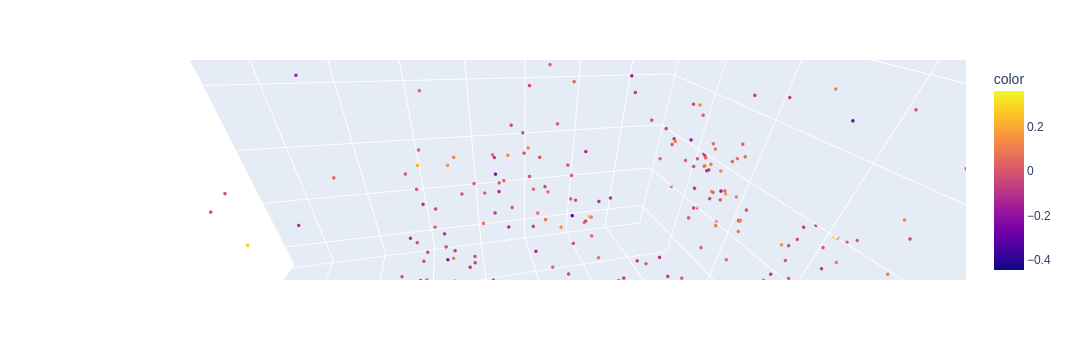

In [20]:
df2visualize = reduced.copy().drop(objects2clear_idx)

fig = px.scatter_3d(df2visualize, x="pc1", y="pc2", z="pc3", color=final_scaled_ridge_residuals)
fig.update_traces(marker_size = 2)
fig.show()

I've tried to visualize our residuals for several principal component but have noticed nothing obvious in terms of dependence from the principal component variables.

But it can be that we can try to make more sophisticated general prediction trying to predict the residuals with some model. (Try some kind of manual "boosting" rather than some built-in boosting in some library)

We will save residuals of the model which will give us the best submission result.

Let's finally try to submit the prediction of our Ridge regression after feature selection and outlier removing

In [21]:
scaled_ridge_sub_X = scaled_sub[features2select]

scaled_ridge_sub_prediction = np.exp(final_scaled_ridge_reg.predict(scaled_ridge_sub_X))

scaled_ridge_sub_df = pd.DataFrame({"Id": data_sub["Id"], "SalePrice": scaled_ridge_sub_prediction})
scaled_ridge_sub_df.to_csv("models/linear_models/scaled_ridge.csv", index=False)

Our new submission gave us public score equal to **0.13138** which is a good improvement with respect to our baseline ridge model with score of **0.14027**

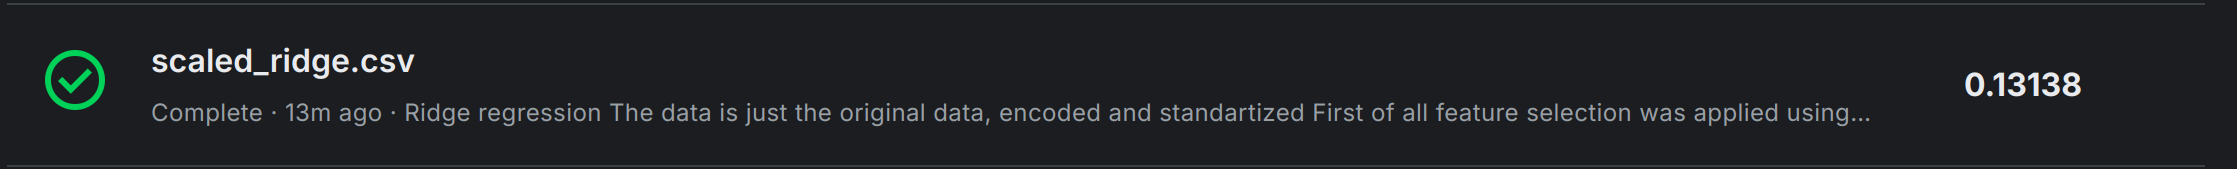

What the most important thing we need to notice? Yes we have updated our public score. BUT we have pretty strong difference between the score we have received with LOO cross validation and the public score. Let's check simple root mean squared error on our train dataset

In [22]:
root_mean_squared_error(final_scaled_ridge_y, final_scaled_ridge_reg.predict(final_scaled_ridge_X))

0.08975368914345631

From here we can understand that **either we have not specified the model correctly or cross validation is not enough to detect overfitting**.

There can be one more thing. It can be that the creators of kaggle competition **have not splitted the whole dataset into train and submission subsets correctly according to the statistical properties of the data**. And here we should to do additional investigation in our train and test datasets to detect if they are similar in terms of those statistical properties.

I will make new third EDA file for this question and after the investigation I'll try to add some specific validation to our training

<a id="pca-data"></a>
## PCA-transformed Data

Now we will try another approach. Let's take our PCA-transformed dataset and apply simple OLS to it. Then we can also make coefficients and residuals analysis.

In [23]:
reduced_X, reduced_y = reduced.drop("SalePrice", axis=1), reduced["SalePrice"]

### PCA decorrelating effect

PCA has a very usefull property. Features, created by PCA are uncorrelated. That means that we can use simple Linear Regression for our data and don't be afraid that we can receive some large model coefficients because of the multicollinearity problem. We can ensure in this by taking corr() method in our reduced data

<Axes: >

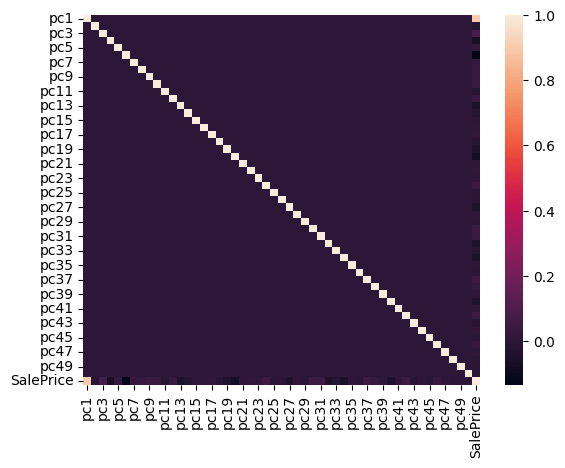

In [24]:
sns.heatmap(reduced.corr())

<a id="ols"></a>
## OLS-regression

In [45]:
ols_reg = LinearRegression()

scores = cross_val_score(ols_reg, reduced_X, reduced_y,
                         scoring="neg_root_mean_squared_error", cv=10)

print("CV-10 MEAN SCORE", -scores.sum() / 10)

ols_reg = LinearRegression().fit(reduced_X, reduced_y)

print("TRAIN ERROR", root_mean_squared_error(reduced_y, ols_reg.predict(reduced_X)))

CV-10 MEAN SCORE 0.14608981771175028
TRAIN ERROR 0.13781583705175202


<a id="ols-coefficients"></a>
## Coefficients Analysis

In [46]:
ols_coefs = pd.DataFrame({"feature": reduced_X.columns.values, "coefficient": ols_reg.coef_})

The most significant features are

In [47]:
ols_coefs.iloc[ols_coefs["coefficient"].abs().sort_values(ascending=False).index].head(n=5)

feature  coefficient
0      pc1     0.125090
5      pc6    -0.043809
41    pc42     0.042567
33    pc34    -0.038921
30    pc31     0.035840

The most insignificant features are

In [48]:
ols_coefs.iloc[ols_coefs["coefficient"].abs().sort_values().index].head(n=10)

feature  coefficient
14    pc15     0.000071
28    pc29    -0.000649
24    pc25    -0.001730
34    pc35     0.002426
20    pc21     0.002593
25    pc26    -0.002676
15    pc16     0.002771
49    pc50    -0.003298
1      pc2    -0.003836
27    pc28     0.003921

<a id="ols-feature-selection"></a>
## Feature selection

Let's plot the same plot as before and check if feature deleting (by threshold) can lead to better predictions.

In [49]:
thresholds = [0.001 * i for i in range(1, 101)]
scores = []

cv = 10
for threshold in tqdm(thresholds):
    features2select = ols_coefs[(ols_coefs["coefficient"].abs() >= threshold)].feature.values
    selected_X = reduced_X[features2select]
    
    selected_ols_reg = LinearRegression()

    score = -cross_val_score(selected_ols_reg, selected_X, reduced_y,
                         scoring="neg_root_mean_squared_error", cv=cv).sum() / cv

    
    scores.append(score)

100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 48.33it/s]


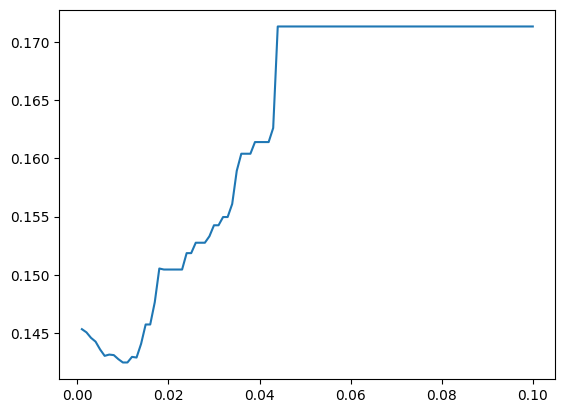

In [50]:
plt.plot(thresholds, scores)
plt.show()

In [51]:
print("BEST THRESHOLD:", thresholds[np.argmin(np.array(scores))])
print("BEST MEAN CV-10 SCORE:", scores[np.argmin(np.array(scores))])

BEST THRESHOLD: 0.01
BEST MEAN CV-10 SCORE: 0.1424797569362409


Let's remove all features with coefficients less than 0.01

In [52]:
features2select = ols_coefs[(ols_coefs["coefficient"].abs() >= 0.01)].feature.values

selected_ols_X = reduced_X[features2select]

print(selected_ols_X.shape)

cv_scores = cross_val_score(LinearRegression(), selected_ols_X, reduced_y,
                         scoring="neg_root_mean_squared_error", cv=10)

print("CV-10 MEAN SCORE", -cv_scores.sum() / 10)

selected_ols_reg = LinearRegression().fit(selected_ols_X, reduced_y)

print("TRAIN ERROR AFTER FEATURE SELECTION:",
      root_mean_squared_error(reduced_y, selected_ols_reg.predict(selected_ols_X)))

(1459, 24)
CV-10 MEAN SCORE 0.1424797569362409
TRAIN ERROR AFTER FEATURE SELECTION: 0.1397201977062147


What we see? We have a little bit better mean CV score than without feature selection but we've also received a little bit bigger train error

<a id="ols-residuals-analysis"></a>
## Residuals Analysis

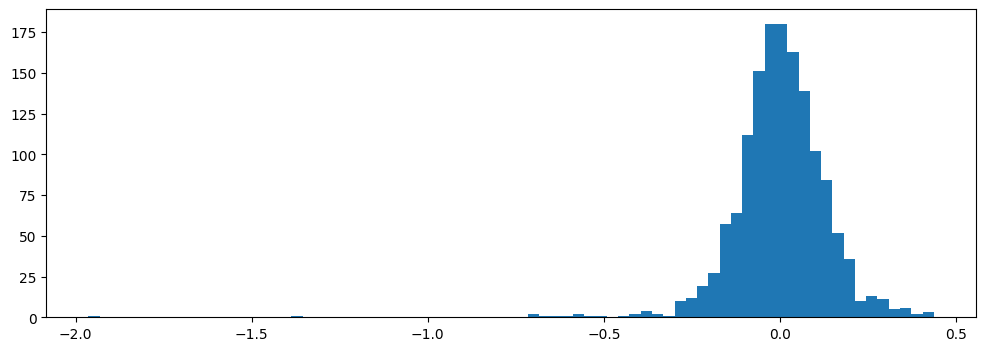

In [53]:
ols_residuals = reduced_y - selected_ols_reg.predict(selected_ols_X)
ols_residuals = pd.DataFrame({"residuals": ols_residuals})
plt.figure(figsize=(12, 4))
plt.hist(ols_residuals["residuals"], bins=75)
plt.show()

What difference we see with respect to the residuals after ridge regression? There are also some objects with abnormal error but they are even futher from the whole set of resuduals. Let's also use some threshold to eliminate our outliers

In [55]:
ols_residuals[(ols_residuals["residuals"].abs() > 0.4)].shape[0]

16

<a id="ols-submission"></a>
## OLS Final training and submission

In [58]:
objects2clear_idx = selected_ols_X[ols_residuals["residuals"].abs() > 0.4].index

print("IDX OF OBJECTS TO DELETE:", objects2clear_idx.values)

final_ols_X = selected_ols_X.copy().drop(objects2clear_idx)
final_ols_y = reduced_y.copy().drop(objects2clear_idx)

print(final_ols_X.shape)

final_ols_reg = LinearRegression().fit(final_ols_X, final_ols_y)

cv_scores = cross_val_score(LinearRegression(), final_ols_X, final_ols_y,
                         scoring="neg_root_mean_squared_error", cv=10)

print("FINAL CV-10 MEAN SCORE", -cv_scores.sum() / 10)

print("FINAL TRAIN ERROR:", root_mean_squared_error(final_ols_y, final_ols_reg.predict(final_ols_X)))

IDX OF OBJECTS TO DELETE: [  30  410  462  495  523  632  681  688  710  812  916  968 1181 1298
 1324 1431]
(1443, 24)
FINAL CV-10 MEAN SCORE 0.11010478554391885
FINAL TRAIN ERROR: 0.10779731318759661


In [59]:
final_ols_residuals = final_ols_y - final_ols_reg.predict(final_ols_X)

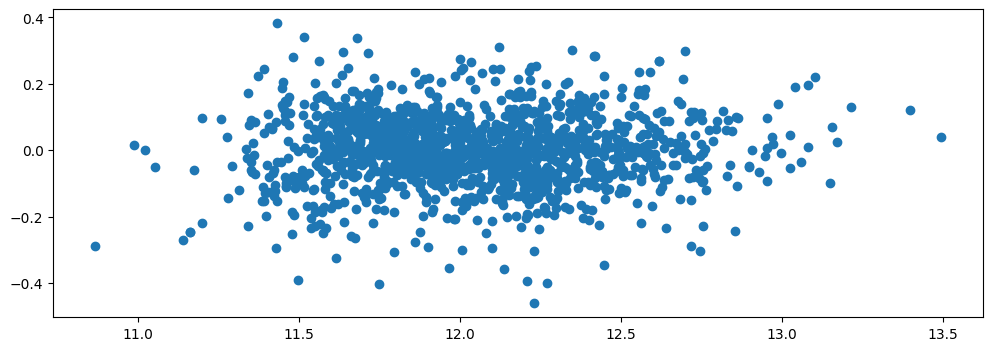

In [60]:
plt.figure(figsize=(12, 4))
plt.scatter(final_ols_reg.predict(final_ols_X), final_ols_residuals)

Let's submit our simple OLS prediction on pca-transformed features 

In [61]:
ols_sub_X = reduced_sub[features2select]

ols_sub_prediction = np.exp(final_ols_reg.predict(ols_sub_X))

ols_sub_df = pd.DataFrame({"Id": data_sub["Id"], "SalePrice": ols_sub_prediction})
ols_sub_df.to_csv("models/linear_models/pca_ols.csv", index=False)

Such an approach gave us even worse result as the baeline models

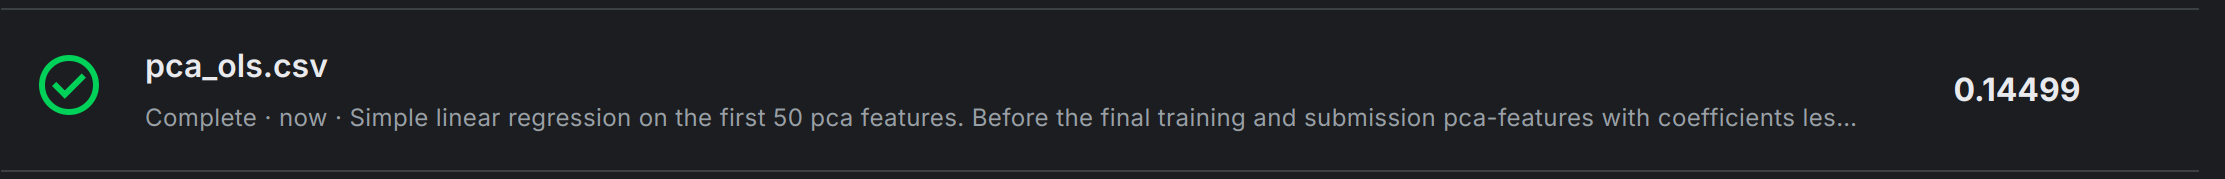

<a id="ridge-general-trend"></a>

### Ridge for general trend and some other model for outliers

Before we end this file I want to write one idea for futher modelating. Perhaps our difference in score between local validation and kaggle validation exists not because of some statistical difference in validation and train sets but because our objects which we classified as outliers should be also processed because in the validation set there are probably also such objects.

That means that our higher validation error can be the result of such outliers in the validation set. 


To try to squeeze a little more out of our linear models, I want to test another approach. What if we use our Ridge regression to predict some linear trend of our data and classify all objects which are too far from those linear trend as outliers. But then we will not throw them away but use one more model to predict their price. It can be that our data is really partially linear but for the other part our data has another behaviour

<a id="conclusions"></a>
## Conclusions 

What did we learn from this file? Using a linear model with regularization, as well as simple approaches for feature selection and outlier removal, we can improve the initial forecast error.

On the other hand, the error is still prohibitively large. But, despite this, linear models can still be useful for this task. Perhaps we can use them to predict the "general linear trend" of our data and use other approaches to refine our results. Approach with model mixtures we will use in the futher files

**For now our best validation score &ndash; 0.13138** On the kaggle leaderboard (ridge regression with simple feature selection and outliers removing)